In [1]:
import sys
import os

current_dir = os.getcwd()
project_path = os.path.join(current_dir, '..')
sys.path.append(project_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import loss
from mlnn.engine import MLNNEngine
from mlnn.callback import MLNNCallback
from mlnn.optimize import MLNNSteepestDescent, MLNNBFGS

from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

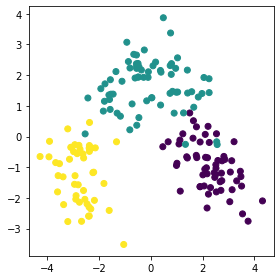

In [3]:
data = load_wine()

X_original = np.array(data['data'])
Y_original = np.array(data['target'], dtype=int)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X_original, Y_original):
    X_train, Y_train = X_original[train_index, :], Y_original[train_index]
    X_test, Y_test = X_original[test_index, :], Y_original[test_index]

X_train, Y_train = X_original, Y_original
X_test, Y_test = X_original, Y_original

pipeline = Pipeline([('std_scaler', StandardScaler())])
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train)

fig.tight_layout()
plt.show()

In [4]:
knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled, Y_train)
Y_test_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"accuracy = {accuracy: .3f}")

accuracy =  0.961


In [5]:
rbf = False

kernel = 'linear'
#kernel = 'nonlinear'

a_mode = 'full'
#a_mode = 'diagonal'
#a_mode = 'decomposed'

e_mode = 'single'
#e_mode = 'multiple'

i_mode = 'zero'
#i_mode = 'random'
#i_mode = 'centered'
#i_mode = 'identity'
#i_mode = 'pca'

keep_a_psd = False
keep_a_centered = False
keep_e_positive = False
check_array_equal = False

n_components = 2

r = 1
s = 0
l = 1
q = 1
inner_loss = loss.SmoothReLU(.5)
outer_loss = loss.SmoothReLU(.5)
#outer_loss = None

optimize_method = 'fixed'
initialization = i_mode
min_delta_F = 1e-6
max_steps = 100
max_time = 1000
fixed_arguments = 'AE'
max_arg_steps = 5

line_search_method = 'backtracking'
use_prev_f = False
alpha_0 = 1e-3
armijo = 1e-6
wolfe = .9
max_ls_iterations = 50

In [6]:
X = X_train_scaled
Y = Y_train
T = np.where(np.equal(Y.reshape(-1, 1), Y.reshape(1, -1)), 1, -1)
N = np.sum(T == 1, axis=1, keepdims=True) - 1

sigma2 = 10 ** 1.12
P = X @ X.T
D = P.diagonal().reshape(-1, 1) + P.diagonal().reshape(1, -1) - 2 * P
G = np.exp(D / (-2 * sigma2))

In [7]:
if kernel == 'linear':
    B = X
elif kernel == 'nonlinear':
    if rbf:
        B = G
    else:
        B = G

if kernel == 'linear':
    C = None
elif kernel == 'nonlinear':
    #C = B
    C = None

In [8]:
mlnn_params = {
    'r': r,
    's': s,
    'l': l,
    'q': q,
    'inner_loss': inner_loss,
    'outer_loss': outer_loss,
    'kernel': kernel,
    'a_mode': a_mode,
    'e_mode': e_mode,
    'keep_a_psd': keep_a_psd,
    'keep_a_centered': keep_a_centered,
    'keep_e_positive': keep_e_positive,
    'check_array_equal': check_array_equal,
}

optimize_params = {
    'optimize_method': optimize_method,
    'initialization': initialization,
    'min_delta_F': min_delta_F,
    'max_steps': max_steps,
    'max_time': max_time,
    'fixed_arguments': fixed_arguments,
    'max_arg_steps': max_arg_steps,
}

line_search_params = {
    'line_search_method': line_search_method,
    'use_prev_f': use_prev_f,
    'alpha_0': alpha_0,
    'armijo': armijo,
    'wolfe': wolfe,
    'max_ls_iterations': max_ls_iterations,
}

In [9]:
mlnn = MLNNEngine(B, T, N, C, mlnn_params)
callback = MLNNCallback(print_stats=True)
optimizer = MLNNSteepestDescent(mlnn, callback=callback, n_components=n_components,
                                optimize_params=optimize_params,
                                line_search_params=line_search_params)
optimizer.minimize(verbose=False)
optimizer.report()

step  args iter   alpha       phi      delta_F       F          R          S          L        mean_E   actv_rows actv_cols actv_data
    0  -    -       -          -          -       5.283e+03  0.000e+00  0.000e+00  5.283e+03  0.000e+00       178       178       178
    1  AE     9  6.938e-07 -8.455e+10  3.395e+03  1.888e+03  2.033e-02  0.000e+00  1.888e+03 -6.960e-03        89       178       178
    2  AE     4  2.371e-06 -1.535e+09  1.616e+03  2.719e+02  1.477e-02  0.000e+00  2.719e+02  5.165e-03        20       178       178
    3  AE     3  1.867e-05 -4.873e+07  1.331e+02  1.388e+02  1.454e-02  0.000e+00  1.388e+02  1.142e-02        18       178       178
    4  AE     2  5.013e-06 -1.745e+08  6.127e+01  7.755e+01  1.686e-02  0.000e+00  7.753e+01  1.005e-02         8       178       178
    5  AE     3  7.993e-06 -2.276e+07  6.013e+01  1.742e+01  1.595e-02  0.000e+00  1.740e+01  1.246e-02         6       178       178
    6  AE     2  1.040e-05 -3.102e+06  1.086e+01  6.560e+00  1

In [10]:
line_search_params['line_search_method'] = 'strong_wolfe'
mlnn = MLNNEngine(B, T, N, C, mlnn_params)
callback = MLNNCallback(print_stats=True)
optimizer = MLNNSteepestDescent(mlnn, callback=callback, n_components=n_components,
                                optimize_params=optimize_params,
                                line_search_params=line_search_params)
optimizer.minimize(verbose=False)
optimizer.report()

step  args iter   alpha       phi      delta_F       F          R          S          L        mean_E   actv_rows actv_cols actv_data
    0  -    -       -          -          -       5.283e+03  0.000e+00  0.000e+00  5.283e+03  0.000e+00       178       178       178
    1  AE     9  6.938e-07 -8.455e+10  3.395e+03  1.888e+03  2.033e-02  0.000e+00  1.888e+03 -6.960e-03        89       178       178
    2  AE     3  2.317e-06 -1.535e+09  1.611e+03  2.770e+02  1.481e-02  0.000e+00  2.769e+02  4.892e-03        20       178       178
    3  AE     4  1.589e-05 -4.853e+07  2.289e+02  4.806e+01  1.342e-02  0.000e+00  4.804e+01  1.047e-02        10       178       178
    4  AE     2  7.256e-06 -1.582e+07  2.609e+01  2.197e+01  1.396e-02  0.000e+00  2.196e+01  1.016e-02         6       178       178
    5  AE     2  1.638e-05 -2.722e+06  2.155e+01  4.241e-01  1.331e-02  0.000e+00  4.108e-01  1.244e-02         2       178       178
    6  AE     4  5.657e-06 -3.351e+05  4.103e-01  1.383e-02  1

In [11]:
mlnn = MLNNEngine(B, T, N, C, mlnn_params)
callback = MLNNCallback(print_stats=True)
optimizer = MLNNBFGS(mlnn, callback=callback, n_components=n_components,
                     optimize_params=optimize_params,
                     line_search_params=line_search_params)
optimizer.minimize(verbose=False)
optimizer.report()

step       delta_F       F          R          S          L        mean_E   actv_rows actv_cols actv_data
    0         -       5.283e+03  0.000e+00  0.000e+00  5.283e+03  0.000e+00       178       178       178
    1      8.213e+02  4.462e+03  4.726e-02  0.000e+00  4.462e+03 -1.061e-02       139       178       178
    2      2.026e+03  2.436e+03  4.182e-02  0.000e+00  2.436e+03 -3.475e-03        97       178       178
    3      1.891e+03  5.449e+02  3.739e-02  0.000e+00  5.449e+02  1.374e-02        25       178       178
    4      2.582e+02  2.867e+02  3.596e-02  0.000e+00  2.867e+02  1.531e-02        18       178       178
    5      1.774e+02  1.093e+02  3.498e-02  0.000e+00  1.093e+02  1.817e-02        11       178       178
    6      5.739e+01  5.192e+01  3.487e-02  0.000e+00  5.189e+01  2.109e-02         7       178       178
    7      2.307e+01  2.885e+01  3.623e-02  0.000e+00  2.882e+01  2.539e-02         7       178       178
    8      1.830e+01  1.055e+01  3.625e-02  0.